In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

import librosa
import librosa.display

from dotenv import load_dotenv
from sklearn.model_selection import train_test_split

In [4]:
load_dotenv()

True

# Preparar las etiquetas

Cargar archivo de anotaciones y comprobar que existe

In [3]:
anot = os.getenv('PMEMO_ANOTATIONS')
stat_anot_file = os.path.join(anot,'static_annotations.csv')

if os.path.exists(stat_anot_file):
    print("El archivo existe")
else:
    print("No hay no existe")
    
anotaciones_df = pd.read_csv(stat_anot_file)
anotaciones_df.head(5)

El archivo existe


,musicId,Arousal(mean),Valence(mean)
0,1,0.4000,0.5750
1,4,0.2625,0.2875
2,5,0.1500,0.2000
3,6,0.5125,0.3500
4,7,0.7000,0.7250


In [4]:
labels = anotaciones_df[['Arousal(mean)','Valence(mean)']].values
print(labels)

[[0.4    0.575 ]
 [0.2625 0.2875]
 [0.15   0.2   ]
 ...
 [0.7125 0.6625]
 [0.875  0.775 ]
 [0.6625 0.575 ]]


# Preparar los espectrogramas

Cargar los espectrogramas ajustados

In [5]:
ASSETS_DIR = os.getenv('ASSETS_DIR')
spect_file = 'padded_spectrograms.pkl'
spect_dir = os.path.join(ASSETS_DIR,spect_file)

#Comprobar que existe el archivo
if os.path.exists(spect_dir):
    with open (spect_dir,'rb') as f:
        spectrograms = pickle.load(f)
    print('Todo bien')
else:
    print('El archivo de espectrogramas no existe')
    spectrograms = None
    

Todo bien


In [6]:
spectrograms = np.array(spectrograms)
print(type(spectrograms))
print(type(spectrograms[0]))
print(spectrograms[0].shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1025, 1671)


In [7]:
spectrograms = np.expand_dims(spectrograms, axis=-1)
print(spectrograms.shape)
print(spectrograms[0].shape)

(767, 1025, 1671, 1)
(1025, 1671, 1)


# Dividir los datos

In [8]:
#Entrenamiento y pruebas
X_train,X_test,y_train,y_test = train_test_split( spectrograms,
                                                 labels,
                                                 test_size=0.2,
                                                 random_state=83)
#Entrenamiento y validación
X_train,X_val, y_train,y_val =  train_test_split( X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=83)

# Normalizar?

In [9]:
# Asumiendo que `spectrograms_array` es tu array de espectrogramas
print("Valor mínimo:", np.min(spectrograms))
print("Valor máximo:", np.max(spectrograms))
print("Media:", np.mean(spectrograms))
print("Desviación estándar:", np.std(spectrograms))

Valor mínimo: -80.0
Valor máximo: 3.8146973e-06
Media: -45.260674
Desviación estándar: 22.533312


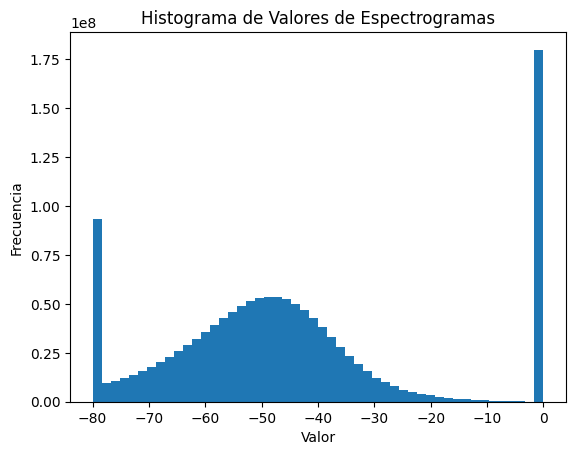

In [10]:
# Aplana el array para facilitar la visualización
values = spectrograms.flatten()

plt.hist(values, bins=50)
plt.title('Histograma de Valores de Espectrogramas')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

In [11]:
# Obtener un resumen estadístico
stats = {
    'Mínimo': np.min(values),
    'Máximo': np.max(values),
    'Media': np.mean(values),
    'Desviación Estándar': np.std(values),
    '25º Percentil': np.percentile(values, 25),
    '50º Percentil (Mediana)': np.percentile(values, 50),
    '75º Percentil': np.percentile(values, 75)
}

for key, value in stats.items():
    print(f'{key}: {value}')

Mínimo: -80.0
Máximo: 3.814697265625e-06
Media: -45.26067352294922
Desviación Estándar: 22.53331184387207
25º Percentil: -59.588809967041016
50º Percentil (Mediana): -48.456809997558594
75º Percentil: -36.96426773071289


In [12]:
# Normalizar los datos
X_train_norm = X_train / np.max(X_train)
X_val_norm = X_val / np.max(X_val)
X_test_norm = X_test / np.max(X_test)

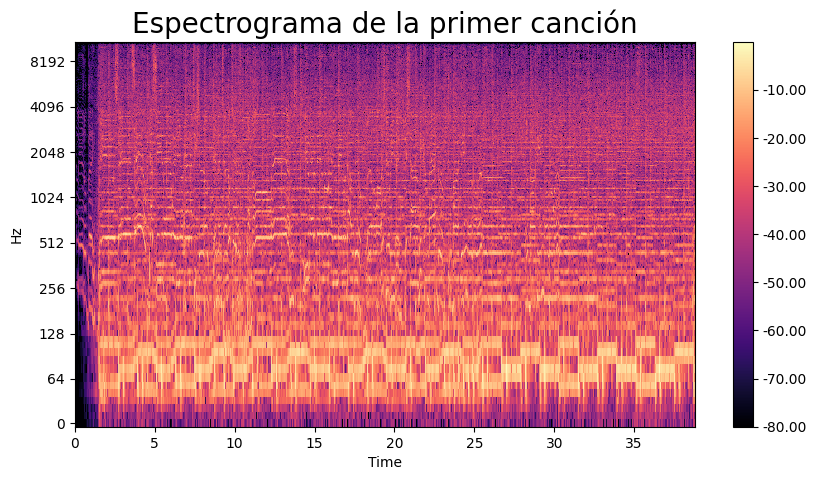

In [18]:
# Graficar el espectrograma de la primer canción
aux_spec = np.squeeze(X_train[1])


#Visualizar
fig,ax = plt.subplots(figsize=(10,5))

img = librosa.display.specshow(aux_spec,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)

ax.set_title('Espectrograma de la primer canción',fontsize=(20))
fig.colorbar(img,ax=ax,format=f'%0.2f')

plt.show()

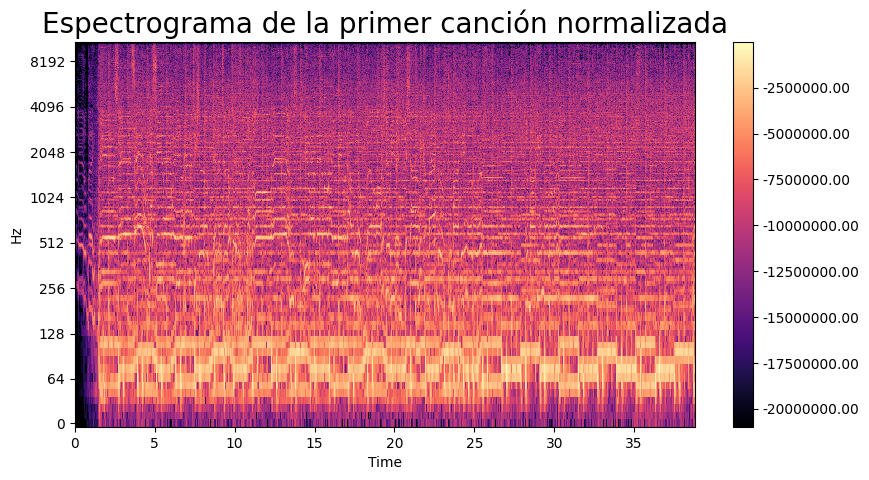

In [20]:
# Graficar el espectrograma de la primer canción pero normalizada
espectrograma_normalizado = np.squeeze(X_train_norm[1])
# Visualizar el espectrograma normalizado
fig,ax = plt.subplots(figsize=(10,5))

img = librosa.display.specshow(espectrograma_normalizado,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Espectrograma de la primer canción normalizada',fontsize=(20))
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [21]:
# Normalizar los datos
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm

## Guardar datos procesados

In [7]:
import h5py

In [24]:
# Guardar los datos en un archivo .h5
DATOS_DIR = os.path.join(ASSETS_DIR,'processed_data.h5')

with h5py.File(DATOS_DIR, 'w') as hf:
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('X_test', data=X_test)
    hf.create_dataset('X_val', data=X_val)
    hf.create_dataset('y_train', data=y_train)
    hf.create_dataset('y_test', data=y_test)
    hf.create_dataset('y_val', data=y_val)

## Cargar datos procesados

In [8]:
# Cargar los datos desde un archivo .h5
DATOS_DIR = os.path.join(ASSETS_DIR,'processed_data.h5')
with h5py.File(DATOS_DIR, 'r') as hf:
    X_train = hf['X_train'][:]
    X_test = hf['X_test'][:]
    X_val = hf['X_val'][:]
    y_train = hf['y_train'][:]
    y_test = hf['y_test'][:]
    y_val = hf['y_val'][:]

# CNN

In [29]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam

In [27]:
# Paso 3: Definir el modelo CNN
model = Sequential([
    InputLayer(input_shape=(1025, 1671, 1)),
    
    # Primera capa convolucional
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Segunda capa convolucional
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Tercera capa convolucional
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Cuarta capa convolucional (opcional)
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Aplanar y pasar a capas densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    
    # Capa de salida con dos neuronas para valence y arousal
    Dense(2, activation='linear')  # Predice los dos valores continuos
])

# Paso 4: Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Mostrar la arquitectura del modelo
model.summary()

# Paso 5: Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

# Evaluar el modelo
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation MAE: {mae}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1025, 1671, 32)    320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 835, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 512, 835, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 835, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 417, 64)     0         
 2D)                                                             
                                                        